In [1]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Any, Tuple, Callable, Optional, Set
import torch
from torch import Tensor
import sys
import os

from experiments.utils import print_nameshape, print_tensor

def remove_outliers(data: np.ndarray, q: float = 0.99) -> np.ndarray:
    return data[data<np.quantile(data, q)]

def plot_histogram(mc, normal_iid_empirical, spherical_iid_empirical):
    conformance = remove_outliers(mc)
    gaussian = remove_outliers(normal_iid_empirical)
    spherical = remove_outliers(spherical_iid_empirical)

    fig = px.histogram(conformance, nbins=1000)
    fig.update_layout(bargap=0.0)
    fig.show()
    plt.plot(np.sort(conformance), np.linspace(0, 1, len(conformance), endpoint=False), label="Conformance")
    plt.plot(np.sort(gaussian), np.linspace(0, 1, len(gaussian), endpoint=False), label="Limiting iid |Z-Y_i| gaussian")
    plt.plot(np.sort(spherical), np.linspace(0, 1, len(spherical), endpoint=False), label="Limiting iid |Z-Y_i| spherical")
    plt.legend(loc="lower right")
    plt.show()

In [2]:
def iid_normal_nn(N_simu:int = 10000,
                   d:int = 2,   #dimension of gaussian vector
                   n:int = 50,  #corpus size
                   seed=0,
                   device = "cuda",
                   ):
    with torch.no_grad():
        # set seed
        torch.manual_seed(seed)
        np.random.seed(seed)

        # iid normals to take distance to
        Y = np.random.randn(N_simu, n, d)
        Y = torch.from_numpy(Y).to(device)
        # new sample
        Z = np.random.randn(N_simu, 1, d)
        Z = torch.from_numpy(Z).to(device)

        diff = torch.norm(Y - Z, dim=-1)
        nndist, _ = torch.min(diff, dim=-1)
        nndist = nndist.cpu().numpy()
        return nndist


def iid_spherical_nn(N_simu:int = 10000,
                   d:int = 2,   #dimension of gaussian vector
                   n:int = 50,  #corpus size
                   seed=0,
                   device = "cuda",
                   ):
    with torch.no_grad():
        # set seed
        torch.manual_seed(seed)
        np.random.seed(seed)

        # iid first d coordinates of sqrt(n) S^{n-1} variables to take distance to
        Y = np.random.randn(N_simu, n, n)
        Y = torch.from_numpy(Y).to(device)
        Y = Y / torch.norm(Y, dim=-1, keepdim=True)
        Y = np.sqrt(n) * Y[:, :, :d]

        # new sample
        Z = np.random.randn(N_simu, 1, d)
        Z = torch.from_numpy(Z).to(device)

        diff = torch.norm(Y - Z, dim=-1)
        nndist, _ = torch.min(diff, dim=-1)
        nndist = nndist.cpu().numpy()
        return nndist

In [3]:
from tqdm import tqdm

@torch.jit.script
def calc_nn(corpus:Tensor, new_sample:Tensor, n:int):
    with torch.no_grad():
        #invert empirical Cov matrix
        U, S, Vt = torch.svd(corpus)
        XtX_sqrtinv = Vt @ torch.diag_embed(S**-1) @ Vt.permute(0, 2, 1)
        differences = corpus - new_sample.unsqueeze(1)
        transformed = differences @ XtX_sqrtinv
        nn = n**0.5 * torch.norm(transformed, dim=-1)
        nn, _ = torch.min(nn, dim=-1)
        return nn



def general_d_simu(N_simu:int = 100000,
                   d:int = 2,   #dimension of gaussian vector
                   n:int = 50,  #corpus size
                   seed = 0,
                   device = "cuda",
                   batch_size = 10000,
                ):
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    #obtain Cov matrix
    cov = np.random.normal(size = (d,d))
    cov = cov @ cov.T

    mc = []
    batch_size = min(batch_size, N_simu)
    for i in range(N_simu//batch_size):
        #generate normals
        corpus = np.random.multivariate_normal(np.zeros(d), cov, size=(batch_size, n))
        corpus = torch.from_numpy(corpus).to(device)
        new_sample = np.random.multivariate_normal(np.zeros(d), cov, size=(batch_size))
        new_sample = torch.from_numpy(new_sample).to(device)
        mc.append(calc_nn(corpus, new_sample, n))

    mc = torch.concatenate(mc).cpu().numpy()

    normal_iid_empirical = iid_normal_nn(N_simu, d, n)
    spherical_iid_empirical = iid_spherical_nn(N_simu, d, n)

    plot_histogram(mc, normal_iid_empirical, spherical_iid_empirical)

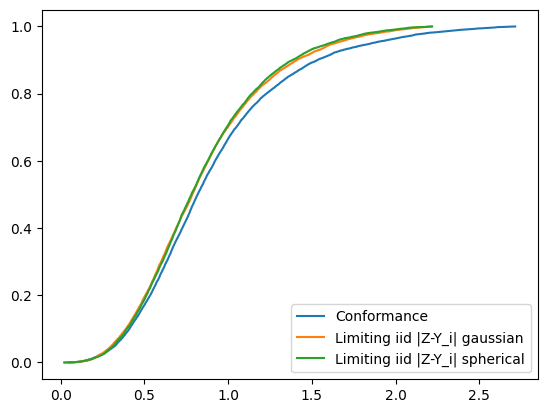

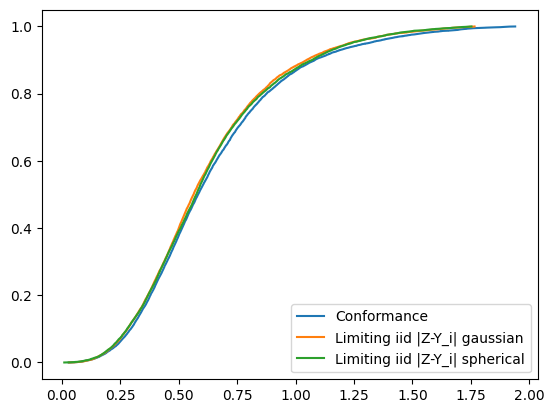

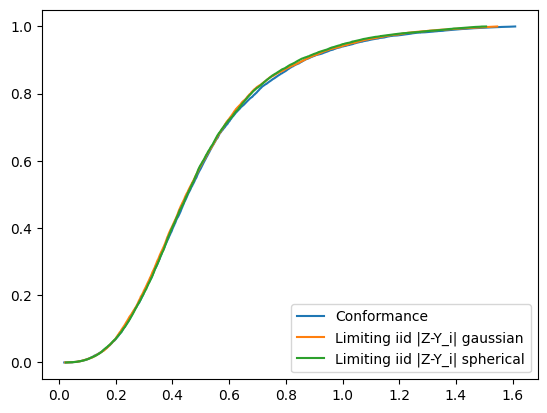

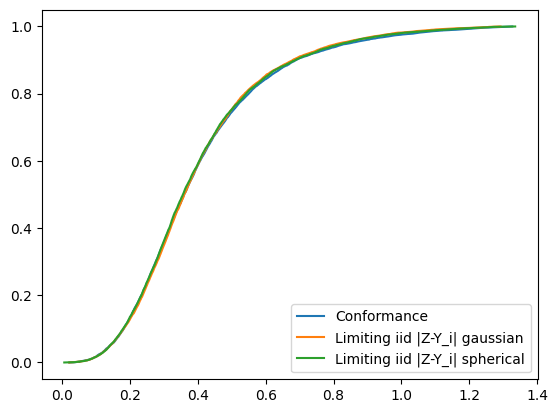

In [4]:
general_d_simu(
    N_simu=10000,
    d=3,
    n=20,
)
general_d_simu(
    N_simu=10000,
    d=3,
    n=50,
)
general_d_simu(
    N_simu=10000,
    d=3,
    n=100,
)
general_d_simu(
    N_simu=10000,
    d=3,
    n=200,
)